In [0]:
%%capture
! kaggle datasets download -d paultimothymooney/blood-cells
! unzip blood-cells.zip -d 'zips/'
! unzip "zips/*.zip" -d "data/"
! rm -r 'data/__MACOSX'

In [0]:
%matplotlib inline

# Math / Visualization / Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [0]:
# Image
import cv2, PIL
from scipy.interpolate import splprep, splev

In [130]:
# ML
# TF
try:
    %tensorflow_version 2.x # %tensorflow_version only exists in Colab.
except Exception:
    pass
import tensorflow.keras as keras

# Scikit
import sklearn
from sklearn import preprocessing, model_selection, metrics

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # %tensorflow_version only exists in Colab.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# Utilities
import glob, os, random, tqdm

In [0]:
def show(image, cmap = None):
    plt.imshow(image, cmap = cmap), plt.axis('off')
    plt.show()

def store(name, image):
    cv2.imwrite(name, image)

def get_yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

In [0]:
filepaths = glob.glob('data/dataset-master/JPEGImages' + '/**/*.jpg', recursive = True)

In [0]:
rind = random.randint(0, len(filepaths))

In [0]:
src = cv2.imread(filepaths[rind], 1)
image = cv2.imread(filepaths[rind], 1)

In [406]:
image.shape

(480, 640, 3)

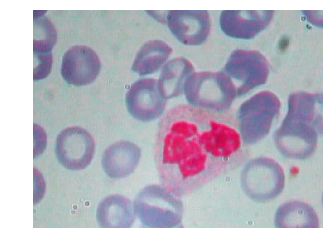

In [407]:
normalizedImg = np.zeros(src.shape[:-1])
normalizedImg = cv2.normalize(image.copy(),  normalizedImg, 0, 255, cv2.NORM_MINMAX)
show(normalizedImg)
img = normalizedImg

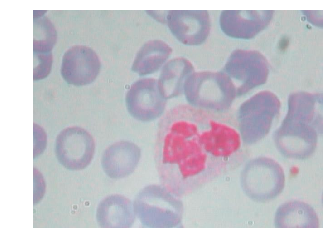

In [408]:
show(image)

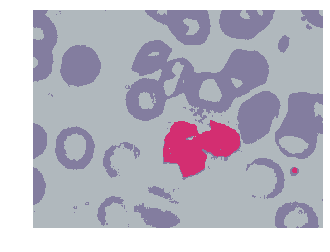

In [409]:
def kmeans(image):
    # K Means segmentation

    #image = source
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    K = 3
    ret, label, center = cv2.kmeans(Z, K, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)

    output = center[label.flatten()]
    output = output.reshape((image.shape))

    #show(output)

    store('kmeans.jpg', output)

    return output

output = kmeans(normalizedImg)
show(output)

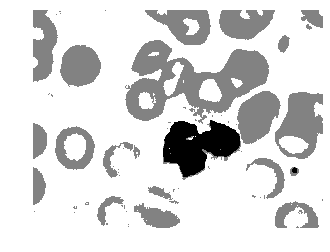

In [410]:
def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = to_gray(output)
show(gray, cmap = 'gray')

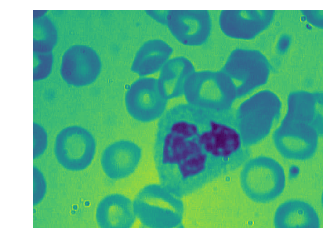

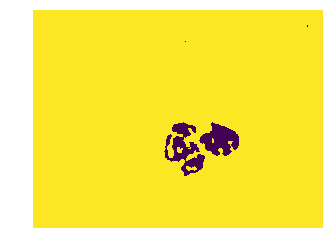

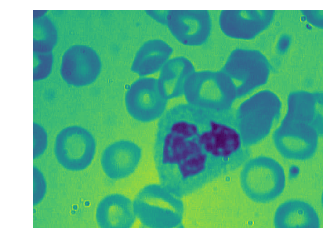

numpy.ndarray

In [411]:
# isolate leukocyte

def threshold(image): # for WBCs
    # Threshold original image
    image = cv2.cvtColor(normalizedImg, cv2.COLOR_BGR2GRAY)
    #image = cv2.medianBlur(image, 15)
    show(image)

    ret, thresh = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)
    thresh_mean = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh_gaussian = cv2.adaptiveThreshold(image, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    titles = ['Original Image', 'Global Thresholding (v = 127)', 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    images = [image, thresh, thresh_mean, thresh_gaussian]

    # for i in range(len(images)):
    #     plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    #     plt.title(titles[i])
    #     plt.xticks([]), plt.yticks([])
        
    # plt.show()
    store('thresh.jpg', thresh)
    store('image.jpg', image)

    return thresh, image

thresh, image = threshold(src) # rgb

show(thresh), show(image)

type(thresh)
# thresh is the nucleus


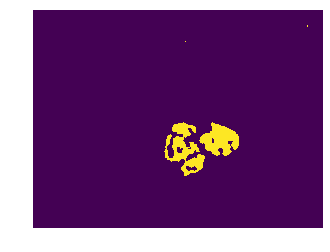

Number of leukocytes = 1


1

In [412]:
def count_leukocytes(image):
    # Count WBCs
    image = cv2.bitwise_not(thresh)

    hough = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 4, 512, param1 = 1, param2 = 150, minRadius = 0, maxRadius = 0)

    for i in hough[0,:]:
        # draw the outer circle
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # draw the center of the circle
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

    show(image)

    #len(hough)
    print("Number of leukocytes =", hough.shape[1])
    return hough.shape[1]    

count_leukocytes(src)

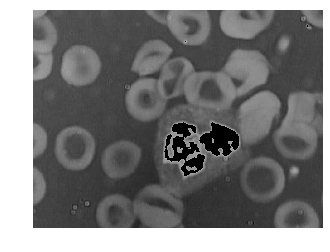

In [413]:
def diff(images):
        return cv2.subtract(images[0], images[1])

def get_subtracted(image):
    #import PIL
    thresh = cv2.imread('thresh.jpg')
    image = cv2.imread('image.jpg')

    subtracted = diff([thresh, image])
    #show(subtracted)
    store('subtracted.jpg', subtracted)
    return subtracted

subtracted = get_subtracted(image)
show(subtracted)

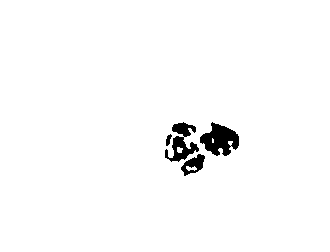

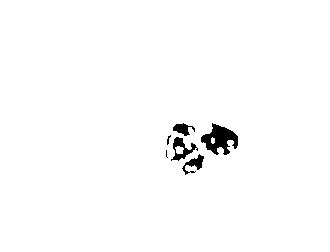

(None, None)

In [414]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img = cv2.imread('thresh.jpg')
dilation = cv2.dilate(img, kernel, iterations = 1)
erosion = cv2.erode(dilation, kernel, iterations = 1)
show(erosion), show(dilation)

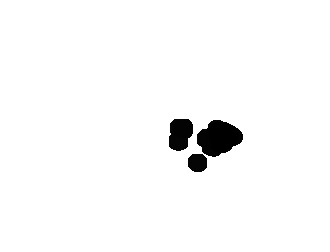

In [417]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
morph_img = cv2.morphologyEx(cv2.imread('thresh.jpg'), cv2.MORPH_CLOSE, kernel)
morph_img = cv2.erode(morph_img, kernel, iterations = 1)
show(morph_img)

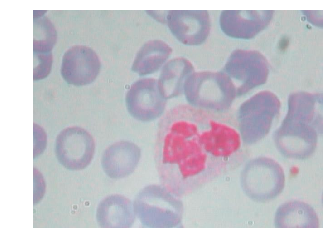

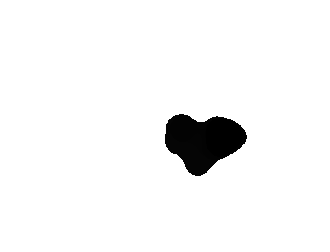

# of Possible WBCs 1


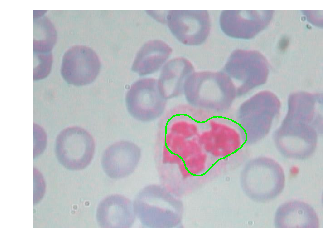

In [418]:
#draw 
show(src)
# load the imagecv2.imread
img = morph_img
#show(img)
erosion = cv2.erode(img.copy(), kernel, iterations = 1)
img = erosion
#show(img)
img = cv2.medianBlur(img, 35)
show(img)


# find all the 'black' shapes in the image
lower = np.array([0, 0, 0])
upper = np.array([150, 150, 150])
shapeMask = cv2.inRange(img, lower, upper)

im, contours, hierarchy = cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print ("# of Possible WBCs %d" % (len(contours)))
#show(shapeMask)

img2 = src.copy()
largest_areas = sorted(contours, key = cv2.contourArea)
cv2.drawContours(img2, [max(contours, key = cv2.contourArea)], -1, (0, 250, 0), 2)
show(img2)

# loop over the contours

# for contour in contours:
#     # draw the contour and show it
#     if cv2.contourArea(contour) > 0:
#         print(cv2.contourArea(contour))
#         cv2.drawContours(img, [contour], -1, (0, 250, 0), 2)
#         show(img)